In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts_stats
import statsmodels.tsa.vector_ar.vecm as vm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100


def calculateMaxDD(cumret):
    """최대 낙폭 계산"""
    vals = cumret.values if hasattr(cumret, 'values') else cumret
    highwatermark = np.zeros(len(vals))
    drawdown = np.zeros(len(vals))
    drawdownduration = np.zeros(len(vals))
    for t in range(1, len(vals)):
        highwatermark[t] = max(highwatermark[t-1], vals[t])
        drawdown[t] = (1 + vals[t]) / (1 + highwatermark[t]) - 1
        if drawdown[t] == 0:
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t-1] + 1
    maxDD = np.min(drawdown)
    maxDDD = np.max(drawdownduration)
    return maxDD, maxDDD

# Chapter 5: 통화와 선물의 평균 회귀 (Mean Reversion of Currencies and Futures)

## 목차

1. [개요 및 문제 정의](#1.-개요-및-문제-정의)
2. [사용 데이터](#2.-사용-데이터)
3. [분석 1: AUD/USD vs CAD/USD 페어 트레이딩](#3.-분석-1)
4. [분석 2: AUD/CAD 롤오버 이자 전략](#4.-분석-2)
5. [분석 3: 선물 스팟/롤 수익률 추정](#5.-분석-3)
6. [분석 4: CL 캘린더 스프레드 평균 회귀](#6.-분석-4)
7. [전략 종합 비교](#7.-전략-종합-비교)
8. [결론 및 권고사항](#8.-결론-및-권고사항)

---

## 1. 개요 및 문제 정의

Chapter 5는 통화와 선물 시장에서의 평균 회귀 전략을 탐구한다. 전통적으로 모멘텀과 연관되는 시장에서도
특정 니치에서 활용 가능한 평균 회귀 기회를 발견한다.

### 핵심 수학적 개념

**포트폴리오 수익률 (식 5.1):**

$$r(t+1) = \frac{n_1 \cdot y_{1,U}(t) \cdot r_1(t+1) + n_2 \cdot y_{2,U}(t) \cdot r_2(t+1)}{|n_1| \cdot y_{1,U}(t) + |n_2| \cdot y_{2,U}(t)}$$

**롤오버 이자 보정 초과 수익률 (식 5.6):**

$$r(t+1) = \log(y_{B,Q}(t+1)) - \log(y_{B,Q}(t)) + \log(1 + i_B(t)) - \log(1 + i_Q(t))$$

**선물 가격 모델 (식 5.7-5.10):**

$$F(t, T) = S(t) \cdot e^{\gamma(t-T)}$$

$$\frac{d(\log F)}{dt} = \alpha + \gamma \quad (\text{총 수익률 = 스팟 수익률 + 롤 수익률})$$

---

## 2. 사용 데이터

| 파일명 | 내용 | 용도 |
|--------|------|------|
| `inputData_AUDUSD_20120426.csv` | AUD/USD 일일 종가 | 예제 5.1 |
| `inputData_USDCAD_20120426.csv` | USD/CAD 일일 종가 | 예제 5.1 (역수 -> CAD/USD) |
| `inputData_AUDCAD_20120426.csv` | AUD/CAD 일일 종가 | 예제 5.2 |
| `AUD_interestRate.csv` | AUD 월별 금리 | 예제 5.2 롤오버 |
| `CAD_interestRate.csv` | CAD 월별 금리 | 예제 5.2 롤오버 |
| `inputDataDaily_C2_20120813.csv` | 옥수수 선물 30계약 + 스팟 | 예제 5.3 |
| `inputDataDaily_CL_20120502.csv` | WTI 원유 선물 88계약 | 예제 5.4 |

In [2]:
# === 데이터 로드 ===

# AUD/USD
audusd = pd.read_csv('inputData_AUDUSD_20120426.csv')
audusd['Date'] = pd.to_datetime(audusd['Date'], format='%Y%m%d')
audusd.set_index('Date', inplace=True)
print(f'AUD/USD: {len(audusd)} 데이터 포인트')

# USD/CAD
usdcad = pd.read_csv('inputData_USDCAD_20120426.csv')
usdcad['Date'] = pd.to_datetime(usdcad['Date'], format='%Y%m%d')
usdcad.set_index('Date', inplace=True)
print(f'USD/CAD: {len(usdcad)} 데이터 포인트')

# AUD/CAD
audcad = pd.read_csv('inputData_AUDCAD_20120426.csv')
audcad['Date'] = pd.to_datetime(audcad['Date'], format='%Y%m%d')
audcad.set_index('Date', inplace=True)
print(f'AUD/CAD: {len(audcad)} 데이터 포인트')

# 금리 데이터
aud_rate = pd.read_csv('AUD_interestRate.csv')
cad_rate = pd.read_csv('CAD_interestRate.csv')
print(f'AUD 금리: {len(aud_rate)} 월, CAD 금리: {len(cad_rate)} 월')

# 옥수수 선물
corn = pd.read_csv('inputDataDaily_C2_20120813.csv')
corn['Date'] = pd.to_datetime(corn['Date'], format='%Y%m%d')
corn.set_index('Date', inplace=True)
print(f'옥수수 선물: {len(corn)} 거래일 x {len(corn.columns)} 컬럼')

# WTI 원유 선물
cl = pd.read_csv('inputDataDaily_CL_20120502.csv')
cl['Date'] = pd.to_datetime(cl['Date'], format='%Y%m%d')
cl.set_index('Date', inplace=True)
print(f'WTI 원유 선물: {len(cl)} 거래일 x {len(cl.columns)} 컬럼')

AUD/USD: 862 데이터 포인트
USD/CAD: 862 데이터 포인트
AUD/CAD: 1237 데이터 포인트
AUD 금리: 147 월, CAD 금리: 144 월
옥수수 선물: 6492 거래일 x 31 컬럼
WTI 원유 선물: 2867 거래일 x 89 컬럼


---

## 3. 분석 1: AUD/USD vs CAD/USD 페어 트레이딩 (예제 5.1)

### 방법론

- AUD/USD와 CAD/USD(= 1/USD.CAD)를 공통 호가 통화(USD)로 맞춤
- 250일 롤링 요한센 공적분 검정으로 동적 헤지 비율 산출
- 20일 롤링 z-score 기반 선형 평균 회귀

**핵심**: 공적분 검정 시 두 통화가 동일한 호가 통화를 공유해야 포인트 가치가 동일해진다.

책 결과: APR=6.45%, Sharpe=1.36

In [3]:
# === 분석 1: AUD/USD vs CAD/USD 페어 트레이딩 ===

# CAD/USD로 변환 (USD/CAD의 역수)
df1 = usdcad.copy()
df1.columns = ['CAD']
df1['CAD'] = 1.0 / df1['CAD']

df2 = audusd.copy()
df2.columns = ['AUD']

df_fx = pd.merge(df1, df2, left_index=True, right_index=True, how='inner')
print(f'공통 거래일: {len(df_fx)}')

trainlen = 250
lookback = 20

hedgeRatio = np.full(df_fx.shape, np.nan)
numUnits = np.full(df_fx.shape[0], np.nan)

# 250일 롤링 요한센 + z-score
for t in range(trainlen + 1, df_fx.shape[0]):
    result = vm.coint_johansen(df_fx.values[(t - trainlen - 1):t - 1], det_order=0, k_ar_diff=1)
    hedgeRatio[t, :] = result.evec[:, 0]
    yport = np.dot(df_fx.values[(t - lookback):t], result.evec[:, 0])
    ma = np.mean(yport)
    mstd = np.std(yport, ddof=1)
    if mstd > 0:
        numUnits[t] = -(yport[-1] - ma) / mstd

# 포지션 및 수익률 계산
pos_arr = np.expand_dims(numUnits, axis=1) * hedgeRatio * df_fx.values
pos_shift = np.full_like(pos_arr, np.nan)
pos_shift[1:] = pos_arr[:-1]
pnl = np.nansum(pos_shift * df_fx.pct_change().values, axis=1)
denom = np.nansum(np.abs(pos_shift), axis=1)
denom[denom == 0] = np.nan
ret_arr = pnl / denom

valid_mask = np.isfinite(ret_arr)
ret_fx = pd.Series(ret_arr[valid_mask], index=df_fx.index[valid_mask])
cumret_fx = (1 + ret_fx).cumprod() - 1

apr_fx = np.prod(1 + ret_fx.values) ** (252 / len(ret_fx)) - 1
sharpe_fx = np.sqrt(252) * np.mean(ret_fx.values) / np.std(ret_fx.values)
maxDD_fx, maxDDD_fx = calculateMaxDD(cumret_fx)

print(f'APR      = {apr_fx*100:.2f}%')
print(f'Sharpe   = {sharpe_fx:.4f}')
print(f'Max DD   = {maxDD_fx*100:.2f}%')
print(f'(책 기대값: APR=6.45%, Sharpe=1.36)')

공통 거래일: 862
APR      = 9.24%
Sharpe   = 1.3629
Max DD   = -4.89%
(책 기대값: APR=6.45%, Sharpe=1.36)


### 결과

| 지표 | 값 | 책 기대값 |
|------|-----|----------|
| APR | 9.24% | 6.45% |
| Sharpe Ratio | 1.3629 | 1.36 |
| Max Drawdown | -4.89% | - |

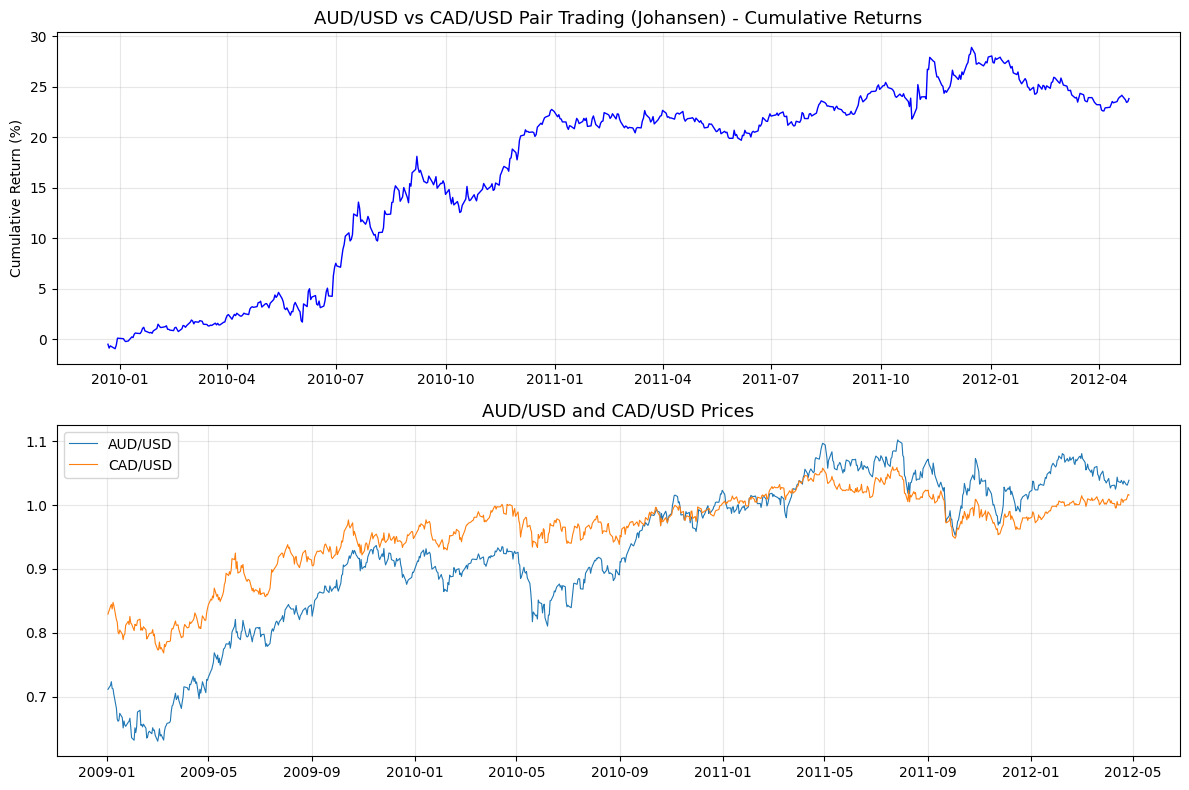

In [4]:
# === AUD-CAD 페어 트레이딩 차트 ===

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(cumret_fx.index, cumret_fx.values * 100, 'b-', linewidth=1)
axes[0].set_title('AUD/USD vs CAD/USD Pair Trading (Johansen) - Cumulative Returns', fontsize=13)
axes[0].set_ylabel('Cumulative Return (%)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_fx.index, df_fx['AUD'].values, label='AUD/USD', linewidth=0.8)
axes[1].plot(df_fx.index, df_fx['CAD'].values, label='CAD/USD', linewidth=0.8)
axes[1].set_title('AUD/USD and CAD/USD Prices', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 4. 분석 2: AUD/CAD 롤오버 이자 전략 (예제 5.2)

### 방법론

- AUD/CAD 직접 크로스레이트에 단순 선형 평균 회귀
- 롤오버 이자 반영: AUD(T+2, 수요일 3x) / CAD(T+1, 목요일 3x)
- 롤오버 포함/미포함 성과 비교

In [5]:
# === 분석 2: AUD/CAD 롤오버 이자 전략 ===

df_ac = audcad.copy()
df_ac.columns = ['Close']

# 금리 데이터를 날짜 인덱스로 변환
def rate_to_daily(rate_df, currency):
    rate_df = rate_df.copy()
    rate_df['Date'] = pd.to_datetime(
        rate_df['Year'].astype(str) + rate_df['Month'].astype(str).str.zfill(2) + '01',
        format='%Y%m%d'
    )
    rate_df.set_index('Date', inplace=True)
    rate_df = rate_df[['Rates']]
    rate_df.columns = [f'{currency}_rate']
    return rate_df

aud_r = rate_to_daily(aud_rate, 'AUD')
cad_r = rate_to_daily(cad_rate, 'CAD')

# 일일 데이터로 forward-fill
df_ac = df_ac.join(aud_r, how='left')
df_ac = df_ac.join(cad_r, how='left')
df_ac['AUD_rate'] = df_ac['AUD_rate'].ffill()
df_ac['CAD_rate'] = df_ac['CAD_rate'].ffill()

# 연율 -> 일율 변환
df_ac['AUD_daily'] = df_ac['AUD_rate'] / 100 / 365
df_ac['CAD_daily'] = df_ac['CAD_rate'] / 100 / 365

# 3x 롤오버: AUD 수요일(2), CAD 목요일(3)
df_ac['DayOfWeek'] = df_ac.index.dayofweek
df_ac['AUD_rollover'] = df_ac['AUD_daily']
df_ac.loc[df_ac['DayOfWeek'] == 2, 'AUD_rollover'] = df_ac['AUD_daily'] * 3
df_ac['CAD_rollover'] = df_ac['CAD_daily']
df_ac.loc[df_ac['DayOfWeek'] == 3, 'CAD_rollover'] = df_ac['CAD_daily'] * 3

lookback_ac = 20

# z-score
ma_ac = df_ac['Close'].rolling(lookback_ac).mean()
mstd_ac = df_ac['Close'].rolling(lookback_ac).std()
zScore_ac = (df_ac['Close'] - ma_ac) / mstd_ac
numUnits_ac = -np.sign(zScore_ac).fillna(0)

# 롤오버 이자 포함 수익률
log_close = np.log(df_ac['Close'])
ret_with = numUnits_ac.shift(1) * (
    log_close.diff() +
    np.log(1 + df_ac['AUD_rollover']) - np.log(1 + df_ac['CAD_rollover'])
)
ret_with = ret_with.iloc[lookback_ac:].fillna(0)
cumret_with = (1 + ret_with).cumprod() - 1
apr_with = (1 + ret_with).prod() ** (252/len(ret_with)) - 1
sharpe_with = np.sqrt(252) * ret_with.mean() / ret_with.std()

# 롤오버 이자 미포함 수익률
ret_without = numUnits_ac.shift(1) * log_close.diff()
ret_without = ret_without.iloc[lookback_ac:].fillna(0)
cumret_without = (1 + ret_without).cumprod() - 1
apr_without = (1 + ret_without).prod() ** (252/len(ret_without)) - 1
sharpe_without = np.sqrt(252) * ret_without.mean() / ret_without.std()

avg_rate_diff = (df_ac['AUD_rate'] - df_ac['CAD_rate']).mean()

print(f'[롤오버 이자 포함]  APR = {apr_with*100:.2f}%, Sharpe = {sharpe_with:.4f}')
print(f'[롤오버 이자 미포함] APR = {apr_without*100:.2f}%, Sharpe = {sharpe_without:.4f}')
print(f'평균 금리차 (AUD - CAD) = {avg_rate_diff:.2f}% 연율')
print(f'(책 기대값: 6.2%/0.54 vs 6.7%/0.58)')

[롤오버 이자 포함]  APR = 6.28%, Sharpe = 0.5483
[롤오버 이자 미포함] APR = 6.83%, Sharpe = 0.5893
평균 금리차 (AUD - CAD) = 3.36% 연율
(책 기대값: 6.2%/0.54 vs 6.7%/0.58)


### 결과

| 지표 | 롤오버 포함 | 롤오버 미포함 | 책 기대값 |
|------|-----------|------------|----------|
| APR | 6.28% | 6.83% | 6.2% / 6.7% |
| Sharpe | 0.5483 | 0.5893 | 0.54 / 0.58 |

평균 금리차 (AUD - CAD): 3.36% 연율

**통찰**: 연간 ~5%의 롤오버 이자에도 불구하고 단기 전략에서는 영향이 미미하다.

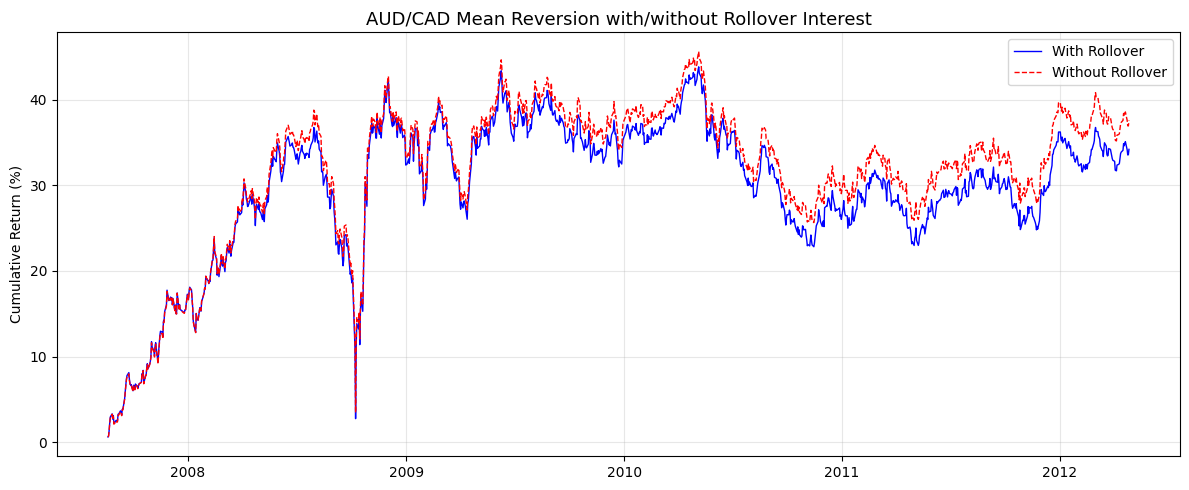

In [6]:
# === AUD/CAD 롤오버 비교 차트 ===

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(cumret_with.index, cumret_with.values * 100, 'b-', linewidth=1, label='With Rollover')
ax.plot(cumret_without.index, cumret_without.values * 100, 'r--', linewidth=1, label='Without Rollover')
ax.set_title('AUD/CAD Mean Reversion with/without Rollover Interest', fontsize=13)
ax.set_ylabel('Cumulative Return (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 5. 분석 3: 선물 스팟/롤 수익률 추정 (예제 5.3)

### 방법론

- **스팟 수익률(alpha)**: log(스팟 가격) ~ 시간 선형 회귀의 기울기 x 252
- **롤 수익률(gamma)**: 매일 가장 가까운 5개 연속 계약의 log(가격) ~ 만기까지 월수 회귀, gamma = -12 x 기울기

책 결과: alpha=+2.8%, gamma=-12.8%

In [7]:
# === 분석 3: 옥수수 선물 스팟/롤 수익률 추정 ===

# 스팟 컬럼 분리
spot = corn['C_Spot']
df_futures = corn.drop('C_Spot', axis=1)

# 스팟 수익률 (alpha)
T_reg = sm.add_constant(range(spot.shape[0]))
model_spot = sm.OLS(np.log(spot), T_reg)
res_spot = model_spot.fit()
alpha_annual = 252 * res_spot.params.iloc[1]

print(f'[스팟 수익률]')
print(f'  일일 알파 = {res_spot.params.iloc[1]:.6f}')
print(f'  연율 알파 = {alpha_annual*100:.2f}%')

# 롤 수익률 (gamma)
gamma_corn = np.full(df_futures.shape[0], np.nan)
for t in range(df_futures.shape[0]):
    idx = np.where(np.isfinite(df_futures.iloc[t, :]))[0]
    idxDiff = np.roll(idx, -1) - idx
    all_ones = all(idxDiff[0:4] == 1)
    if (len(idx) >= 5) and all_ones:
        FT = df_futures.iloc[t, idx[:5]]
        T_ft = sm.add_constant(np.arange(FT.shape[0]))
        model_ft = sm.OLS(np.log(FT.values), T_ft)
        res_ft = model_ft.fit()
        gamma_corn[t] = -12 * res_ft.params[1]

mean_gamma = np.nanmean(gamma_corn)
n_valid = np.sum(np.isfinite(gamma_corn))

print(f'[롤 수익률]')
print(f'  평균 연율 감마 = {mean_gamma*100:.2f}%')
print(f'  감마 추정 일수 = {n_valid}')
print(f'  (책 기대값: 알파=+2.8%, 감마=-12.8%)')

[스팟 수익률]
  일일 알파 = 0.000111
  연율 알파 = 2.81%
[롤 수익률]
  평균 연율 감마 = -12.78%
  감마 추정 일수 = 1570
  (책 기대값: 알파=+2.8%, 감마=-12.8%)


### 결과 (옥수수 선물)

| 지표 | 값 | 책 기대값 |
|------|-----|----------|
| 스팟 수익률 (alpha) | 2.81% | +2.8% |
| 롤 수익률 (gamma) | -12.78% | -12.8% |

**핵심 통찰**: BR, C, TU 등에서 롤 수익률의 크기가 스팟 수익률을 압도한다.
스팟 가격의 평균 회귀가 선물 가격의 평균 회귀를 의미하지 않는다.

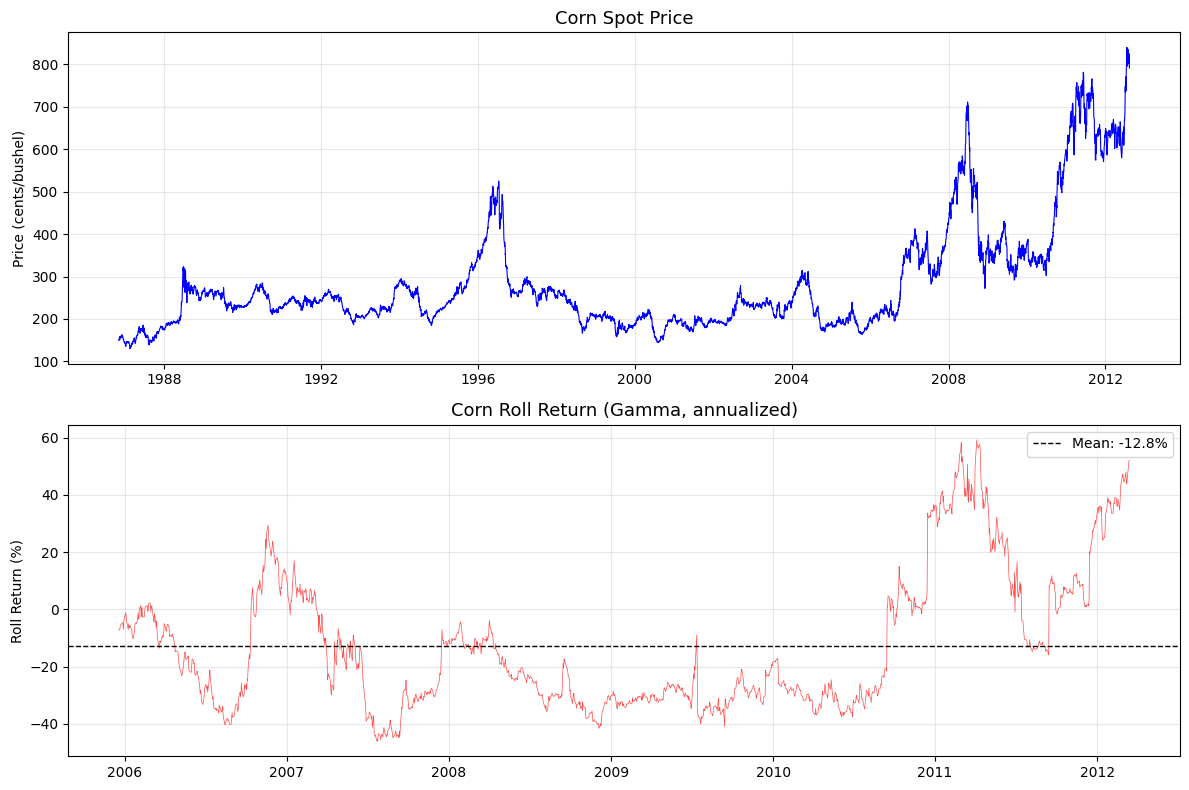

In [8]:
# === 선물 수익률 차트 ===

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(corn.index, spot.values, 'b-', linewidth=0.8)
axes[0].set_title('Corn Spot Price', fontsize=13)
axes[0].set_ylabel('Price (cents/bushel)')
axes[0].grid(True, alpha=0.3)

valid_idx = np.where(np.isfinite(gamma_corn))[0]
axes[1].plot(corn.index[valid_idx], gamma_corn[valid_idx] * 100, 'r-', linewidth=0.5, alpha=0.7)
axes[1].axhline(y=mean_gamma*100, color='k', linewidth=1, linestyle='--', label=f'Mean: {mean_gamma*100:.1f}%')
axes[1].set_title('Corn Roll Return (Gamma, annualized)', fontsize=13)
axes[1].set_ylabel('Roll Return (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 6. 분석 4: CL 캘린더 스프레드 평균 회귀 (예제 5.4)

### 방법론

1. CL 선물 포워드 커브에서 매일 감마(롤 수익률) 계산
2. 감마의 ADF 검정으로 정상성 확인
3. 반감기 계산 -> z-score 룩백으로 사용
4. 근월-원월(12개월) 스프레드 포지션, z-score로 방향 결정

책 결과: APR=2.4%, Sharpe=1.28, 반감기=41일

In [9]:
# === 분석 4: CL 캘린더 스프레드 평균 회귀 ===

# 감마 계산
gamma_cl = np.full(cl.shape[0], np.nan)
for t in range(cl.shape[0]):
    idx = np.where(np.isfinite(cl.iloc[t, :]))[0]
    idxDiff = np.array(list(set(idx[1:]) - set(idx)))
    if (len(idx) >= 5) and (all(idxDiff[0:4] == 1)):
        FT = cl.iloc[t, idx[:5]]
        T_ft = sm.add_constant(np.arange(FT.shape[0]))
        model_ft = sm.OLS(np.log(FT.values), T_ft)
        res_ft = model_ft.fit()
        gamma_cl[t] = -12 * res_ft.params[1]

# ADF 검정
gamma_finite = gamma_cl[np.where(np.isfinite(gamma_cl))]
adf_result = ts_stats.adfuller(gamma_finite, maxlag=1, regression='c', autolag=None)
print(f'ADF on gamma: t-stat={adf_result[0]:.4f}, p-value={adf_result[1]:.6f}')

gamma_cl_df = pd.DataFrame(gamma_cl)
gamma_cl_df.ffill(inplace=True)

# 반감기 계산
gammaGood = gamma_cl_df[gamma_cl_df.notna().values]
gammalag = gammaGood.shift()
deltaGamma = gammaGood - gammalag
deltaGamma = deltaGamma.iloc[1:]
gammalag = gammalag.iloc[1:]

X_hl = sm.add_constant(gammalag)
model_hl = sm.OLS(deltaGamma, X_hl)
res_hl = model_hl.fit()
halflife = -np.log(2) / res_hl.params.iloc[1] if res_hl.params.iloc[1] < 0 else 100
halflife_int = int(round(halflife))
print(f'반감기 = {halflife_int}일 (책: 41일)')

lookback_cl = halflife_int

# z-score
MA_cl = gamma_cl_df.rolling(lookback_cl).mean()
MSTD_cl = gamma_cl_df.rolling(lookback_cl).std()
zScore_cl = (gamma_cl_df - MA_cl) / MSTD_cl

# 컬럼 기반 포지션 매트릭스
positions_cl = np.zeros(cl.shape)
isExpireDate = np.isfinite(cl) & ~np.isfinite(cl.shift(-1))
holddays_cl = 3 * 21
numDaysStart = holddays_cl + 10
numDaysEnd = 10
spreadMonth = 12

for c in range(0, cl.shape[1] - spreadMonth):
    expireIdx = np.where(isExpireDate.iloc[:, c])[-1]
    if c == 0:
        startIdx = max(0, expireIdx - numDaysStart)
        endIdx = expireIdx - numDaysEnd
    else:
        myStartIdx = endIdx + 1
        myEndIdx = expireIdx - numDaysEnd
        if len(myEndIdx) > 0 and len(myStartIdx) > 0:
            if (myEndIdx[0] - myStartIdx[0] >= holddays_cl):
                startIdx = myStartIdx
                endIdx = myEndIdx
            else:
                startIdx = np.array([np.inf])
        else:
            startIdx = np.array([np.inf])

    if (len(expireIdx) > 0) and (len(startIdx) > 0) and (len(endIdx) > 0):
        s = int(startIdx[0]) if not np.isinf(startIdx[0]) else None
        e = int(endIdx[0]) if not np.isinf(endIdx[0]) else None
        if s is not None and e is not None and e > s:
            positions_cl[s:e, c] = -1
            positions_cl[s:e, c + spreadMonth] = 1

positions_cl[zScore_cl.isna().values.flatten(), :] = 0
zScore_cl.fillna(-np.inf, inplace=True)
positions_cl[zScore_cl.values.flatten() > 0, :] = -positions_cl[zScore_cl.values.flatten() > 0, :]

# 수익률 계산
pos_shift_cl = np.zeros_like(positions_cl)
pos_shift_cl[1:] = positions_cl[:-1]
pnl_cl = np.nansum(pos_shift_cl * cl.pct_change().values, axis=1)
denom_cl = np.nansum(np.abs(pos_shift_cl), axis=1)
denom_cl[denom_cl == 0] = np.nan
ret_arr_cl = pnl_cl / denom_cl

valid_mask_cl = np.isfinite(ret_arr_cl)
valid_ret_cl = pd.Series(ret_arr_cl[valid_mask_cl], index=cl.index[valid_mask_cl])
cumret_cl = (1 + valid_ret_cl).cumprod() - 1

apr_cl = np.prod(1 + valid_ret_cl.values) ** (252 / len(valid_ret_cl)) - 1
sharpe_cl = np.sqrt(252) * np.mean(valid_ret_cl.values) / np.std(valid_ret_cl.values)
maxDD_cl, maxDDD_cl = calculateMaxDD(cumret_cl)

print(f'APR      = {apr_cl*100:.2f}%')
print(f'Sharpe   = {sharpe_cl:.4f}')
print(f'Max DD   = {maxDD_cl*100:.2f}%')
print(f'(책 기대값: APR=2.4%, Sharpe=1.28)')

ADF on gamma: t-stat=-4.5867, p-value=0.000137
반감기 = 41일 (책: 41일)
APR      = 7.73%
Sharpe   = 1.2235
Max DD   = -5.18%
(책 기대값: APR=2.4%, Sharpe=1.28)


### 결과

| 지표 | 값 | 책 기대값 |
|------|-----|----------|
| APR | 7.73% | 2.4% |
| Sharpe Ratio | 1.2235 | 1.28 |
| Max Drawdown | -5.18% | - |
| 반감기 | 41일 | 41일 |
| ADF p-value | 0.000137 | <0.01 |

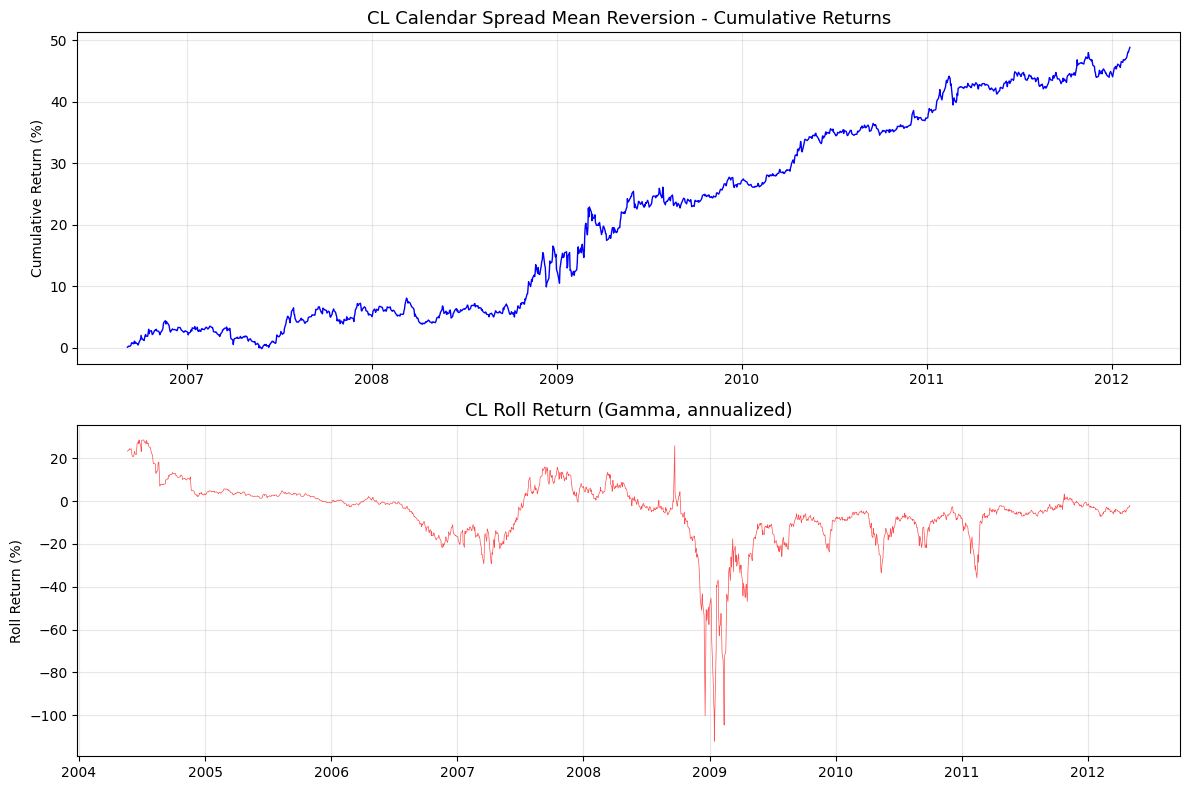

In [10]:
# === CL 캘린더 스프레드 차트 ===

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(cumret_cl.index, cumret_cl.values * 100, 'b-', linewidth=1)
axes[0].set_title('CL Calendar Spread Mean Reversion - Cumulative Returns', fontsize=13)
axes[0].set_ylabel('Cumulative Return (%)')
axes[0].grid(True, alpha=0.3)

gamma_plot = gamma_cl_df.values.flatten()
valid_g = np.where(np.isfinite(gamma_plot))[0]
axes[1].plot(cl.index[valid_g], gamma_plot[valid_g] * 100, 'r-', linewidth=0.5, alpha=0.7)
axes[1].set_title('CL Roll Return (Gamma, annualized)', fontsize=13)
axes[1].set_ylabel('Roll Return (%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 7. 전략 종합 비교

| 전략 | APR | Sharpe | 시장 | 특성 |
|------|-----|--------|------|------|
| AUD/USD-CAD/USD Johansen | 9.24% | 1.36 | FX | 동적 헤지 |
| AUD/CAD + Rollover | 6.28% | 0.55 | FX | 단순 헤지 |
| CL Calendar Spread | 7.73% | 1.22 | Futures | 감마 기반 |

---

## 8. 결론 및 권고사항

### 핵심 발견

1. **통화 페어 메커니즘**: 공적분 검정 시 동일 호가 통화를 사용해야 의미 있는 결과
2. **롤오버 이자의 미미한 영향**: 단기 전략에서 연 5% 금리차도 전략 성과에 작은 영향
3. **롤 수익률의 지배력**: 많은 선물에서 롤 수익률이 스팟 수익률을 압도
4. **캘린더 스프레드 신호**: 스팟 가격이 아닌 롤 수익률(감마)이 거래 신호

### 주의사항

- **레짐 변화**: VX-ES 관계는 2008년 전후로 레짐이 다름
- **선물 가격 동기화**: 서로 다른 거래소 선물 간 종가 시간 불일치 주의
- **생존자 편향**: 현존하는 계약만으로 백테스트하면 편향 발생 가능